In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
files=os.listdir("./data/results")

In [3]:
grid = [s for s in files if "grid" in s] # files with results for grid search
random = [s for s in files if "random" in s] 
group = [s for s in files if "group" in s] 

In [4]:
grid_df=pd.DataFrame([])
for file in grid:
    print("reading:", file)
    df = pd.read_csv("./data/results/"+file)
    
    df['iter_num']=1
    df.loc[df['experiment_name']!='default params', 
           'iter_num'] = range(1, df.loc[df['experiment_name']!='default params'].shape[0]+1)
    
    grid_df = pd.concat([grid_df, df], sort=False)
    print("grid_df shape: ", grid_df.shape) #729 grid run and 1 default

    
print("===============================")
group_df=pd.DataFrame([])
for file in group:
    print("reading:", file)
    df = pd.read_csv("./data/results/"+file)
    
    df['iter_num'] = range(1, df.shape[0]+1)
    
    group_df = pd.concat([group_df, df], sort=False)
    print("group_df shape: ", group_df.shape)
    
print("===============================")
random_df=pd.DataFrame([])
for file in random:
    print("reading:", file)
    df = pd.read_csv("./data/results/"+file)
    
    df['iter_num'] = range(1, df.shape[0]+1)
    
    random_df = pd.concat([random_df, df], sort=False)
    print("random_df shape: ", random_df.shape)
   

reading: xgboost_perfomance_grid_search_GPU.csv
grid_df shape:  (730, 21)
reading: xgboost_perfomance_group_search_GPU_3.csv
group_df shape:  (729, 22)
reading: xgboost_perfomance_group_search_GPU_1.csv
group_df shape:  (1458, 22)
reading: xgboost_perfomance_group_search_GPU_5.csv
group_df shape:  (2187, 22)
reading: xgboost_perfomance_group_search_GPU_4.csv
group_df shape:  (2916, 22)
reading: xgboost_perfomance_group_search_GPU_2.csv
group_df shape:  (3645, 22)
reading: xgboost_perfomance_random_search_GPU_2.csv
random_df shape:  (729, 22)
reading: xgboost_perfomance_random_search_GPU_4.csv
random_df shape:  (1458, 22)
reading: xgboost_perfomance_random_search_GPU_3.csv
random_df shape:  (2187, 22)
reading: xgboost_perfomance_random_search_GPU_1.csv
random_df shape:  (2916, 22)


In [5]:
df = pd.concat([grid_df, group_df, random_df], sort=False)

In [6]:
####### CHANGE IT ################
##############################################

working_time={
    'grid search':3927.89,
    'random params':4134.34,
    'random params in group 1':1171.77,
    'random params in group 2':855.39,
    'random params in group 3':740.36,
    'default params':61.26
}

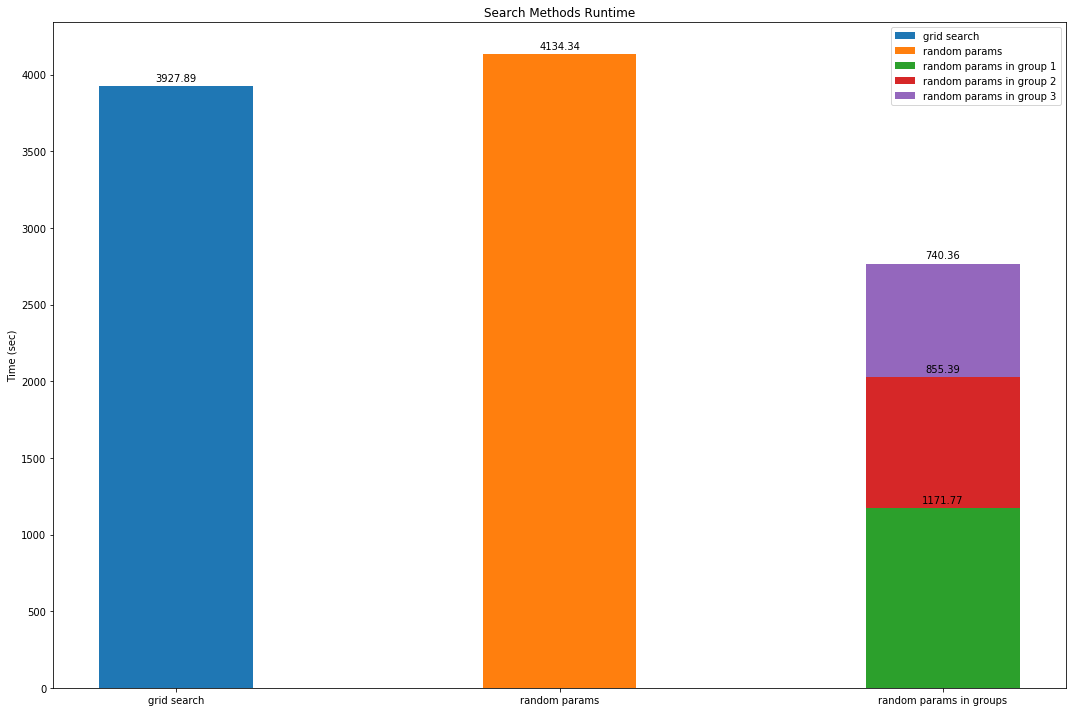

In [7]:
def autolabel(rects, add=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()+add
        ax.annotate('{}'.format(round(height-add,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
x = [0,0.5,1]  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

labels=['grid search','random params', 'random params in groups']
rects1 = ax.bar(0, working_time['grid search'], width, label='grid search')
rects2 = ax.bar(0.5, working_time['random params'], width, label='random params')

rects3_1 = ax.bar(1, working_time['random params in group 1'], width, label='random params in group 1')
rects3_2 = ax.bar(1, working_time['random params in group 2'], width,
             bottom=working_time['random params in group 1'], label='random params in group 2')
rects3_3 = ax.bar(1, working_time['random params in group 3'], width,
             bottom=working_time['random params in group 2'] + working_time['random params in group 1'], 
                  label='random params in group 3')



ax.set_ylabel('Time (sec)')
ax.set_title('Search Methods Runtime')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='best')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3_1)
autolabel(rects3_2, working_time['random params in group 1'])
autolabel(rects3_3, working_time['random params in group 1']+working_time['random params in group 2'])
fig.tight_layout()

plt.savefig("graphs/1_time_exec.jpg")
plt.show()

In [8]:
top5=df.loc[:,['experiment_name','params','mean_test_score']].sort_values(by='mean_test_score',ascending=False)[:5]

In [9]:
top5

,experiment_name,params,mean_test_score
611,random search for 3 group,"{'colsample_bytree': 0.6377829940262529, 'subs...",0.668893
494,random search for 3 group,"{'colsample_bytree': 0.8561761903119284, 'subs...",0.668684
632,random search for 3 group,"{'colsample_bytree': 0.7357267698298404, 'subs...",0.667381
213,random search,"{'alpha': 0.49756682216606285, 'colsample_bytr...",0.667099
584,random search for 3 group,"{'colsample_bytree': 0.518416632682847, 'subsa...",0.667024


In [10]:
for elem in top5.loc[:,'params']:
    print(elem)

{'colsample_bytree': 0.6377829940262529, 'subsample': 0.8194911486224106}
{'colsample_bytree': 0.8561761903119284, 'subsample': 0.8305738637937383}
{'colsample_bytree': 0.7357267698298404, 'subsample': 0.8616109807531065}
{'alpha': 0.49756682216606285, 'colsample_bytree': 0.7402656409962164, 'lambda': 0.8617115096485154, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.866164910824629}
{'colsample_bytree': 0.518416632682847, 'subsample': 0.8109188749423228}


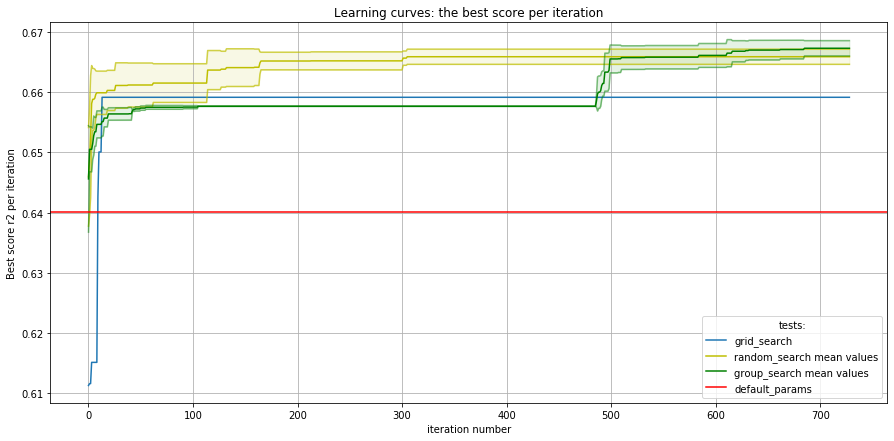

In [11]:
#comparison
# confidence intervals theory get from: 
# https://medium.com/ml-ai-study-group/confidence-interval-confidence-level-be58d250dd40


## GRID_SEARCH
#get best scores per itration for grid_search performance:
grid_perf=grid_df.loc[grid_df['experiment_name']!='default params', 'mean_test_score'].cummax()


## RANDOM_SEARCH
#get best scores per itration for each random_search performance:
random_mean=pd.DataFrame([])
for i in random_df.run_number.unique():
    tmp=pd.DataFrame(random_df.loc[random_df.run_number==i, "mean_test_score"].cummax())
    tmp["iter_num"]=random_df.loc[random_df.run_number==i, "iter_num"]
    random_mean=pd.concat([random_mean, tmp], sort=False)
    
#get mean and confidence interval value for random_search performance on iteration:    

z = 1.96 # for 95% conf interval (coefficient)
# z = 1.64 # for 90% conf interval

n=random_mean.shape[0]/random_mean.iter_num.max() # now n=4, because 4 runs were made for random search
random_std=random_mean.groupby(by="iter_num")['mean_test_score'].std() #std
random_std=(random_std*z)/np.sqrt(n) #confidence interval value 
random_mean=random_mean.groupby(by="iter_num")['mean_test_score'].mean() #mean


## GROUP_SEARCH
#get best scores per itration for each group_search performance (same computations):
group_mean=pd.DataFrame([])
for i in group_df.run_number.unique():
    tmp=pd.DataFrame(group_df.loc[group_df.run_number==i, "mean_test_score"].cummax())
    tmp["iter_num"]=group_df.loc[group_df.run_number==i, "iter_num"]
    group_mean=pd.concat([group_mean, tmp], sort=False)

n=group_mean.shape[0]/group_mean.iter_num.max() # now n=5
group_std=group_mean.groupby(by="iter_num")['mean_test_score'].std()
group_std=(group_std*z)/np.sqrt(n) 
group_mean=group_mean.groupby(by="iter_num")['mean_test_score'].mean()

## DEFAULT performance
default_perf=grid_df.loc[grid_df['experiment_name']=='default params', 'mean_test_score']


## PLOT
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(0, grid_perf.shape[0]))

#grid plot:
plt.plot(x, grid_perf, label="grid_search")

#conf for random:
plt.plot(x, random_mean, color="y", label="random_search mean values")
lower=random_mean - random_std
upper=random_mean + random_std
plt.plot(x, lower, alpha=0.7, color="y")
plt.plot(x, upper, alpha=0.7, color="y")
plt.fill_between(x, lower, upper, alpha=0.1, color="y") 

#conf for group:
plt.plot(x, group_mean, color="green", label="group_search mean values")
lower=group_mean - group_std
upper=group_mean + group_std
plt.plot(x, lower, alpha=0.5, color="green")
plt.plot(x, upper, alpha=0.5, color="green")
plt.fill_between(x, lower, upper, alpha=0.1, color="green")

#line for default values
plt.axhline(default_perf.values, label="default_params", color='r')

plt.legend(title='tests:')
plt.title("Learning curves: the best score per iteration")
plt.ylabel("Best score r2 per iteration")
plt.xlabel("iteration number")
plt.savefig("graphs/2_scores.jpg")
plt.show()

In [12]:
df.experiment_name.unique()

array(['grid search', 'default params', 'random search for 1 group',
       'random search for 2 group', 'random search for 3 group',
       'random search'], dtype=object)

In [13]:
best_scores=df.groupby(by='experiment_name')['mean_test_score'].max().reset_index()
print("best scores:")
print(best_scores)

best=pd.merge(df, best_scores, how='inner', on=['experiment_name','mean_test_score']).loc[:,['experiment_name','mean_test_score', 'params', 'iter_num']]
#best step and params

best scores:
             experiment_name  mean_test_score
0             default params         0.640144
1                grid search         0.659186
2              random search         0.667099
3  random search for 1 group         0.657690
4  random search for 2 group         0.657690
5  random search for 3 group         0.668893


In [14]:
best_iter=best.groupby('experiment_name')['iter_num'].min().reset_index()
params=pd.merge(df, best_iter, how='inner', on=['experiment_name','iter_num'])
#print(params)
print(params.params.values)

["{'alpha': 0.25, 'colsample_bytree': 0.625, 'lambda': 0.25, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.75}"
 "{'max_depth': 3}" "{'max_depth': 6, 'min_child_weight': 7}"
 "{'max_depth': 5, 'min_child_weight': 7}"
 "{'max_depth': 9, 'min_child_weight': 8}"
 "{'max_depth': 4, 'min_child_weight': 2}"
 "{'max_depth': 5, 'min_child_weight': 9}"
 "{'alpha': 0.9330022742340969, 'lambda': 0.5178966486922677}"
 "{'alpha': 0.05406848165072475, 'lambda': 0.11082662983789626}"
 "{'alpha': 0.005497150740957357, 'lambda': 0.5676367511987901}"
 "{'alpha': 0.47749657657650113, 'lambda': 0.2559384019646358}"
 "{'alpha': 0.8310507007919129, 'lambda': 0.19046961514517324}"
 "{'colsample_bytree': 0.6147894454877889, 'subsample': 0.6010950316603609}"
 "{'colsample_bytree': 0.8811080883324838, 'subsample': 0.7227296866267281}"
 "{'colsample_bytree': 0.6377829940262529, 'subsample': 0.8194911486224106}"
 "{'colsample_bytree': 0.7981328757849755, 'subsample': 0.7603490676294218}"
 "{'colsample_byt

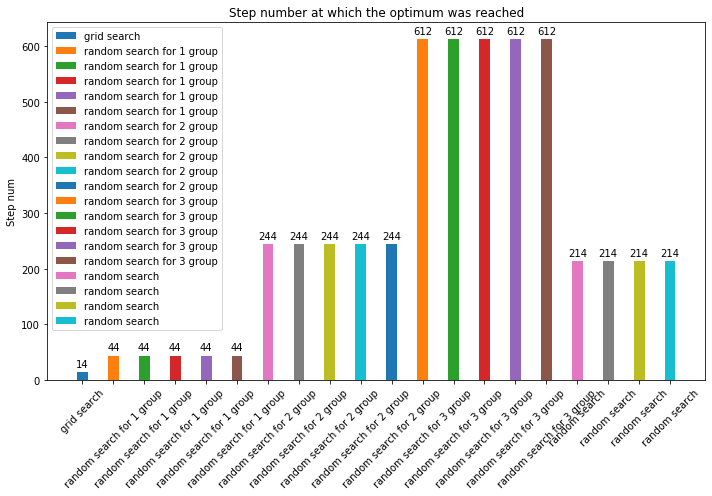

In [15]:
# on which min step algo get best result 
import math
params=params.loc[params['experiment_name']!='default params'].reset_index(drop=True)
x = np.arange(params.shape[0])  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))

labels=params.loc[:,'experiment_name']
rects=[]
for row in range(params.shape[0]):
    rects.append(ax.bar(row, params.loc[row,'iter_num'], width, label=params.loc[row,'experiment_name']))
    autolabel(rects[row])

ax.set_ylabel('Step num')
ax.set_title('Step number at which the optimum was reached')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

fig.tight_layout()

plt.savefig("graphs/3_best_step.jpg")
plt.show()

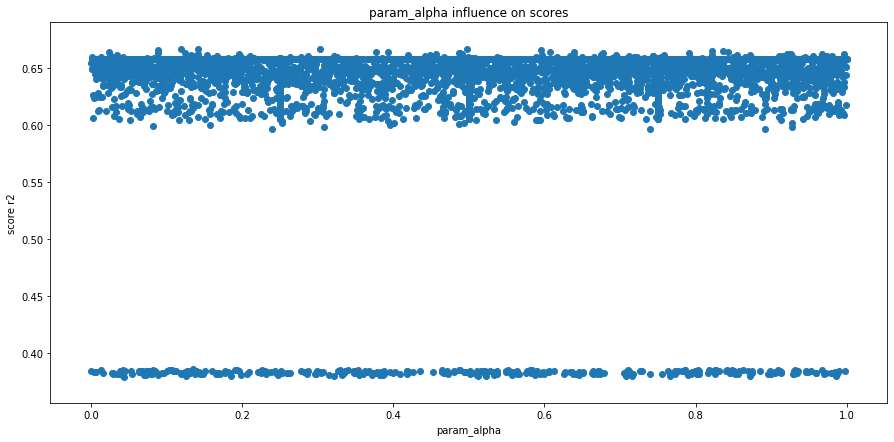

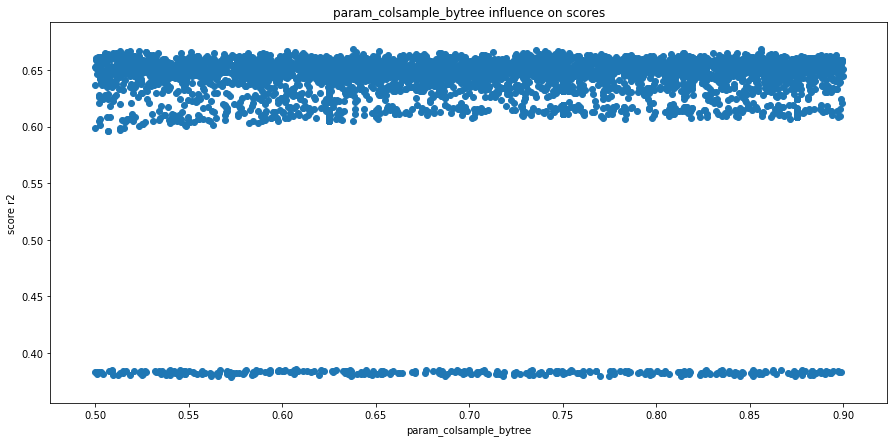

KeyError: 'param_gamma'

In [16]:
#params influence


params_list=['param_alpha', 'param_colsample_bytree',
       'param_gamma', 'param_lambda', 'param_max_depth',
       'param_min_child_weight', 'param_subsample']

for param in params_list:
    df.loc[:,param].unique().sort

    plt.figure(figsize=(15,7))
    x=df.loc[:,param]
    y=df.loc[:,'mean_test_score']
    plt.scatter(x, y)

    plt.title(param+" influence on scores")
    plt.xlabel(param)
    plt.ylabel("score r2")
    plt.savefig("graphs/4 {} influence.jpg".format(param))
    plt.show()